**Author**: Petru Potrimba <br>
**Matriculation**:  928850

# Visual Inspection of Motorcycle Connecting Rods

### Utility function

In [307]:
def potrimba_algorithm(imgf):
    img, contours, hierarchy = cv.findContours(imgf.copy(), cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)

    # get the contour index of touching rods
    sepc = -1
    for i in range(len(contours)):
        if(len(contours[i])) >= 256: # there are touching elements
            sepc = i
            break

    collision_points = []
    
    if sepc != -1: # if there are touching rods, add them
        for i in range(len(contours[sepc])):
            if (contours[sepc][i][0][0] - 1 >= 0) and (contours[sepc][i][0][1] - 1 >= 0) and (contours[sepc][i][0][0] + 1 <= 255) and (contours[sepc][i][0][1] + 1 <= 255):
                octet = int(img[contours[sepc][i][0][1] - 1, contours[sepc][i][0][0]]) + int(img[contours[sepc][i][0][1] - 1, contours[sepc][i][0][0] - 1]) + int(img[contours[sepc][i][0][1], contours[sepc][i][0][0] - 1]) + int(img[contours[sepc][i][0][1] + 1, contours[sepc][i][0][0] - 1]) + int(img[contours[sepc][i][0][1] + 1, contours[sepc][i][0][0]]) + int(img[contours[sepc][i][0][1] + 1, contours[sepc][i][0][0] + 1]) + int(img[contours[sepc][i][0][1], contours[sepc][i][0][0] + 1]) + int(img[contours[sepc][i][0][1] - 1, contours[sepc][i][0][0] + 1])
                if octet == 255 or octet == 510:
                    collision_points.append([contours[sepc][i], False])

    if len(collision_points) > 0:
        # calculate euclidean distance
        for i in range(len(collision_points) - 1):
            distance_from_i_to_j = math.inf
            index_of_j = -1
            if collision_points[i][1] == False: # means that still need to find its miniumum distance point
                for j in range(i + 1, len(collision_points)):
                    dst = distance.euclidean(collision_points[i][0][0], collision_points[j][0][0])
                    if dst < distance_from_i_to_j and collision_points[j][1] == False:
                        distance_from_i_to_j = dst
                        index_of_j = j
                # draw line
                cv.line(img,(collision_points[i][0][0][0],collision_points[i][0][0][1]),(collision_points[index_of_j][0][0][0],collision_points[index_of_j][0][0][1]),(255,0, 0),1)
                collision_points[i][1] = True
                collision_points[index_of_j][1] = True
    return img

In [308]:
def defect_convexity_algorithm(imgf):
    
    img, contours, hierarchy = cv.findContours(imgf.copy(), cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
    
    sepc = -1
    for i in range(len(contours)):
        if(len(contours[i])) >= 256: # there are touching elements
            sepc = i
            break
    
    cnt = contours[sepc]
    hull = cv.convexHull(cnt, returnPoints = False)
    defects = cv.convexityDefects(cnt, hull)

    collision_points = []
    
    if sepc != -1: # if there are touching rods, add them
         for i in range(defects.shape[0]):
            s,e,f,d = defects[i,0]
            far = tuple(cnt[f][0])
            if (far[0] - 1 >= 0) and (far[1] - 1 >= 0) and (far[0] + 1 <= 255) and (far[1] + 1 <= 255) and (far[0] - 2 >= 0) and (far[1] - 2 >= 0) and (far[0] + 2 <= 255) and (far[1] + 2 <= 255):
                octet_sum = int(img[far[1] - 1, far[0]]) + int(img[far[1] - 1, far[0] - 1]) + int(img[far[1], far[0] - 1]) + int(img[far[1] + 1, far[0] - 1]) + int(img[far[1] + 1, far[0]]) + int(img[far[1] + 1, far[0] + 1]) + int(img[far[1], far[0] + 1]) + int(img[far[1] - 1, far[0] + 1]) + int(img[far[1] - 2, far[0]]) + int(img[far[1] - 2, far[0] - 1]) + int(img[far[1] - 2, far[0] - 2]) + int(img[far[1] -1, far[0] - 2]) + int(img[far[1], far[0] - 2]) + int(img[far[1] + 1, far[0] - 2]) + int(img[far[1] + 2,far[0] - 2]) + int(img[far[1] + 2, far[0] - 1]) + int(img[far[1] + 2, far[0]]) + int(img[far[1] + 2, far[0] + 1]) + int(img[far[1] + 2, far[0] + 2]) + int(img[far[1] + 1, far[0] + 2]) + int(img[far[1], far[0] + 2]) + int(img[far[1] - 1, far[0] + 2]) + int(img[far[1] - 2, far[0] + 2]) + int(img[far[1] - 2, far[0] + 1])
                #if octet_sum == 255 or octet_sum == 510:
                collision_points.append([far, octet_sum, False])
                
    # calculate threshold            
    white_pixel_value_sum = []
    for i in range(len(collision_points)):
        white_pixel_value_sum.append(collision_points[i][1])
    remove_duplicate_list = np.sort(list(set(white_pixel_value_sum)))
    
    changes_between_values = []
    for i in range(len(remove_duplicate_list) - 1):
        changes_between_values.append(remove_duplicate_list[i + 1] - remove_duplicate_list[i])
    max_change = np.argmax(changes_between_values)
    threshold = int(round((remove_duplicate_list[max_change + 1] + remove_duplicate_list[max_change]) / 2))
    
    
    if len(collision_points) > 0:
        # calculate euclidean distance
        for i in range(len(collision_points) - 1):
            distance_from_i_to_j = math.inf
            index_of_j = -1
            if collision_points[i][1] <= threshold and collision_points[i][2] == False: # means that still need to find its miniumum distance point
                for j in range(i + 1, len(collision_points)):
                    #dst = distance.euclidean(collision_points[i][0][0], collision_points[j][0][0])
                    dst = distance.euclidean([collision_points[i][0][0], collision_points[i][0][1]], [collision_points[j][0][0], collision_points[j][0][1]])
                    if dst < distance_from_i_to_j and collision_points[j][2] == False:
                        distance_from_i_to_j = dst
                        index_of_j = j
                # draw line
                cv.line(img,(collision_points[i][0][0],collision_points[i][0][1]),(collision_points[index_of_j][0][0],collision_points[index_of_j][0][1]),(255,0, 0),1)
                collision_points[i][2] = True
                collision_points[index_of_j][2] = True
                
    return img

### Original mage

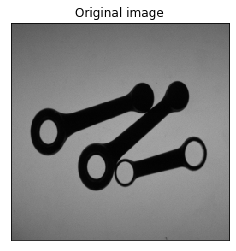

In [309]:
import cv2 as cv
import numpy as np
from matplotlib import pyplot as plt
from scipy.spatial import distance
import math

plt.figure(figsize=(4,4))

original_img = cv.imread('testImages/TESI51.BMP', 0)
img = original_img.copy()
plt.imshow(img, cmap='gray',vmin=0,vmax=255)
plt.title('Original image'), plt.xticks([]), plt.yticks([])
plt.show()

### Apply Otsu's tresholding

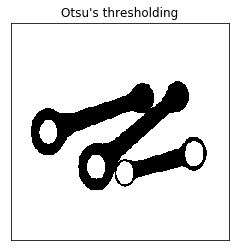

In [310]:
ret, otsu_img = cv.threshold(img, 0, 255, cv.THRESH_BINARY+cv.THRESH_OTSU)
plt.imshow(otsu_img,cmap = 'gray')
plt.title('Otsu\'s thresholding'), plt.xticks([]), plt.yticks([])
plt.show()

### Handling touching rods

#### Potrimba Algorithm

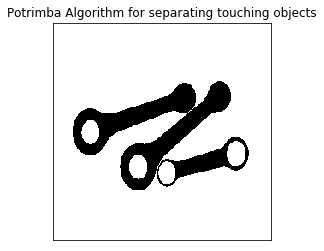

In [311]:
separate_rods_img = potrimba_algorithm(otsu_img)
plt.imshow(separate_rods_img,cmap = 'gray')
plt.title('Potrimba Algorithm for separating touching objects'), plt.xticks([]), plt.yticks([])
plt.show()

#### Defect Convexity Algorithm

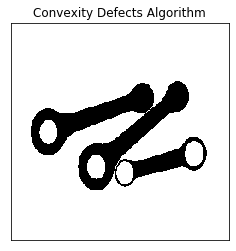

In [312]:
separate_rods_img = defect_convexity_algorithm(otsu_img)
plt.imshow(separate_rods_img,cmap = 'gray')
plt.title('Convexity Defects Algorithm'), plt.xticks([]), plt.yticks([])
plt.show()

### Labeling rods type

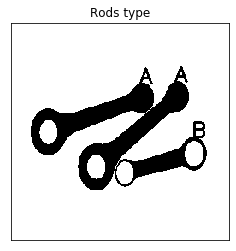

In [301]:
img, contours, hierarchy = cv.findContours(separate_rods_img.copy(), cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
for i in range(hierarchy.shape[1]):
    if hierarchy[0, i][3] == 0 and hierarchy[0, i][2] != -1 and len(contours[i]) >= 72:
        if len(hierarchy[:, np.where(hierarchy[0][:, 3] == i)][0][0]) == 1:
            img = cv.putText(img, 'A', (contours[i][0][0][0], contours[i][0][0][1]), cv.FONT_HERSHEY_SIMPLEX, 0.8, (0, 255, 0), 2, cv.LINE_4)
            plt.imshow(img,cmap = 'gray')
            plt.title('Rods type'), plt.xticks([]), plt.yticks([])
        elif len(hierarchy[:, np.where(hierarchy[0][:, 3] == i)][0][0]) > 1:
            img = cv.putText(img, 'B', (contours[i][0][0][0], contours[i][0][0][1]), cv.FONT_HERSHEY_SIMPLEX, 0.8, (0, 255, 0), 2, cv.LINE_4)
            plt.imshow(img,cmap = 'gray')
            plt.title('Rods type'), plt.xticks([]), plt.yticks([])
            
plt.show()

### Position, orientation, length, width and width at the barycenter Wb 

Position:  (174.78578186035156, 165.9202117919922) , Orientation:  -17.987333297729492
Length:  113.52970886230469 , Width:  40.20663833618164 , Width at the barycenter(Wb):  35.08451461791992
------------------------------------------------------------------------------------------------
Position:  (92.82138061523438, 105.65370178222656) , Orientation:  -24.205886840820312
Length:  154.52609252929688 , Width:  54.26446533203125 , Width at the barycenter(Wb):  45.72482681274414
------------------------------------------------------------------------------------------------
Position:  (140.25, 127.75000762939453) , Orientation:  -45.0
Length:  166.1700897216797 , Width:  49.49747848510742 , Width at the barycenter(Wb):  48.14064407348633
------------------------------------------------------------------------------------------------


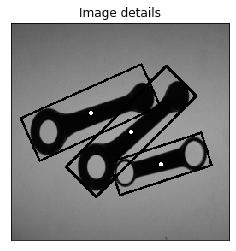

In [302]:
img = original_img.copy()
for i in range(hierarchy.shape[1]):
    if hierarchy[0, i][3] == 0 and hierarchy[0, i][2] != -1 and len(contours[i]) >= 72:
        rect = cv.minAreaRect(contours[i])
        box = cv.boxPoints(rect)
        box = np.int0(box)
        img = cv.drawContours(img,[box],0,(0, 255, 0), 2)
        (x, y),(MA, ma),angle = cv.fitEllipse(contours[i])
        print("Position: ", rect[0], ", Orientation: ", rect[2])
        print("Length: ", rect[1][0] if rect[1][0] > rect[1][1] else rect[1][1], ", Width: ", 
              rect[1][1] if rect[1][1] < rect[1][0] else rect[1][0], ", Width at the barycenter(Wb): ", MA)
        print("------------------------------------------------------------------------------------------------")
        # draw barycenter
        img = cv.circle(img, center=(round(rect[0][0]), round(rect[0][1])), radius=1, color=(255, 0, 0) , thickness=2) 
        plt.imshow(img, cmap = 'gray')
        plt.title('Image details'), plt.xticks([]), plt.yticks([])
plt.show()

### For each hole, position of the centre and diameter size

Centre position:  (132.5, 175.5)
Diameter:  19.32396697998047
------------------------------------------------------------------------------------------------
Centre position:  (213.5, 153.5)
Diameter:  21.360126495361328
------------------------------------------------------------------------------------------------
Centre position:  (43.0, 128.5)
Diameter:  19.96916961669922
------------------------------------------------------------------------------------------------
Centre position:  (99.0, 169.0)
Diameter:  20.820850372314453
------------------------------------------------------------------------------------------------


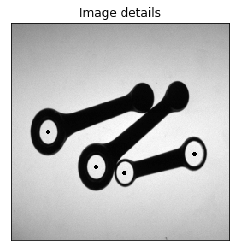

In [303]:
img = original_img.copy()
for i in range(hierarchy.shape[1]):
    if hierarchy[0, i][3] > 0 and len(contours[i]) > 24 and len(contours[hierarchy[0, i][3]]) >= 72: # if the parent of the hole has a perimeter greater than 72 (basically here I am verifying whether the hole's parent is a rod)
        rect = cv.minAreaRect(contours[i])
        box = cv.boxPoints(rect)
        box = np.int0(box)
        (x, y),(MA, ma),angle = cv.fitEllipse(contours[i])
        print("Centre position: ", rect[0])
        print("Diameter: ", MA)
        print("------------------------------------------------------------------------------------------------")
        # draw barycenter
        img = cv.circle(img, center=(round(rect[0][0]), round(rect[0][1])), radius=1, color=(0, 255, 0) , thickness=2) 
        plt.imshow(img, cmap = 'gray')
        plt.title('Image details'), plt.xticks([]), plt.yticks([])
plt.show()

# Project report

## First Task

### Type of rod (A or B)

In order to understand whether a rod has one hole (type A) or two holes (type B), the idea was to use the OpenCV function `findContours` which returns a hierarchical matrix that specifies for each contour the information regarding what is the **next** contour at its same level, the **previous** contour at its same level, who is its **first child** and who is its **parent**.

Using these information it will be easy to classify whether a rod is of type A or B.

But, in order to apply that function, we need a binary image, so the first thing to do is a **segmentation** of the image. <br>
The segmentation algorithm I decided to use is the **Otsu's segmentation** since it effectively calculate an automatic threshold even though the images have been taken by a different lighting power.

Once done that, I used the information returned by *findContours* to classify the rods.

### Position and orientation (modulo $\pi$)

max noise contour == 12

min non noise contour == 35

threshold = (12 + 35) / 2 -> 24

-------

hierarchy[0, i][3] == 0 : if my parent is zero, it means that I'am a rod. <br>
hierarchy[0, i][2] != -1 : if a rod has a first child, it means it is a rod and not a bolt, so it will be analyzed. <br>
len(contours[i]) >= 72 : of the perimeter of the blob took into account is greater than the empirical value 72, it means that it is a rod an not a washers, so it will be analyzed.

------

max area rondella == 64

min area biella == 80

threshold = (64 + 80) / 2 -> 72

------

max area biella == 256

min area touching bielle == 397

threshold for touching elements: (256 + 397) / 2 -> 326